In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint

In [73]:
# function definitions

# second differential using finite differnces
def diffTwo(Z):
    # first order, maybe try higher order
    Zcenter = Z[1:-1]
    Zleft = Z[:-2]
    Zright = Z[2:]
    return (Zleft - 2*Zcenter + Zright) / dx**2

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def discretisation(size, T, increments=101):
    x = np.linspace(0, size, increments)
    dx = x[1] - x[0]
    t = np.linspace(0, T*3600, increments)
    return x, dx, t

# right hand side of simple diffusion equation
def diffusion(u, t, Du):
    dudt = np.zeros_like(u)
    dudt[1:-1] = Du * diffTwo(u)
    # Neumann conditions:
    dudt[0] = 0
    dudt[-1] = 0
    return dudt

# right hand side of 2 component reaction diffusion system
def reactiondiffusion(y, t, Da, delta_a, n, Ka, alpha_g, delta_g):
    varLength = int(len(y)/2)
    a = y[0:varLength]
    g = y[varLength:]
    ac = a[1:-1]
    gc = g[1:-1]
    dydt = np.zeros_like(y)
    dydt[1:varLength-1] = Da*diffTwo(a) - delta_a*ac
    dydt[varLength+1:-1] = (alpha_g*np.power(ac,n))/(np.power(Ka,n)+np.power(ac,n)) - delta_g*gc
    # da/dt, dg/dt equal zero at boundary (Neumann condition)
    return dydt

# returns the full width at half maximum of the front
def frontWidth(g, maxX=50):
    maxTime = np.argmax(g[:,maxX])
    maxValue = g[maxTime,maxX]
    #cond = g>0.5*maxValue
    #return (cond[maxTime,:]==True).sum()
    spline = UnivariateSpline(x[:-1], (g[maxTime,:]-0.5*maxValue), s=0)
    r1, r2 = spline.roots()
    return r2 - r1


# returns the time at which half maximum g is reached
def halfMaxTime(g, maxX=50):
    maxValue = np.max(g[:,maxX])
    cond = g<0.5*maxValue
    return (cond[:,maxX]==True).sum()

Differential equation: 2 component reaction diffusion
$$ \frac{\partial a}{\partial t} = D_a \frac{\partial^2 a}{\partial x^2} - \delta_a a$$
$$ \frac{\partial g}{\partial t} = \frac{\alpha_g \cdot a^n}{K_a^n + a^n} - \delta_g g $$
a is the concentration of AHL, g is GFP

In [105]:
# Parameters

size = 0.1   # meters
T = 30   # hours
x, dx, t = discretisation(size, T, 101)

Da = 5e-10   #m^2/s
delta_a = 1e-4   #1/s
n = 1.8
Ka = 50   #nM? -> halfMaxTime of g
alpha_g = 3e-5   #1/s -> max of g
delta_g = 1e-6   #1/s

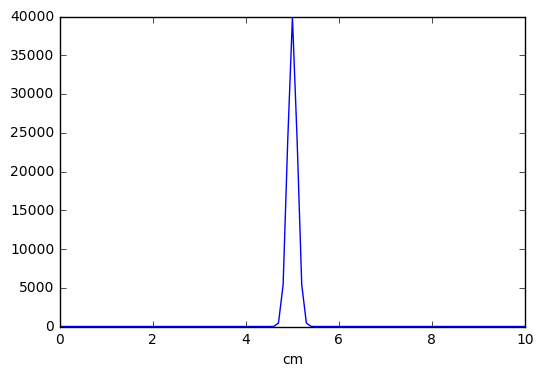

In [106]:
# Initial Conditions

aConcScale = 100
a0 = aConcScale*gaussian(x, 0.05, 0.001)
g0 = np.zeros_like(a0)
#a0 = np.zeros_like(x)
#a0[0:20] = 1.

y0 = np.append(a0,g0)

plt.plot(x*100,a0)
plt.xlabel('cm');

In [107]:
# Run

y = odeint(reactiondiffusion, y0, t, (Da,delta_a,n,Ka,alpha_g,delta_g))
varLength = int(len(y[0,:])/2)
a = y[:,0:varLength-1]
g = y[:,varLength:-1]

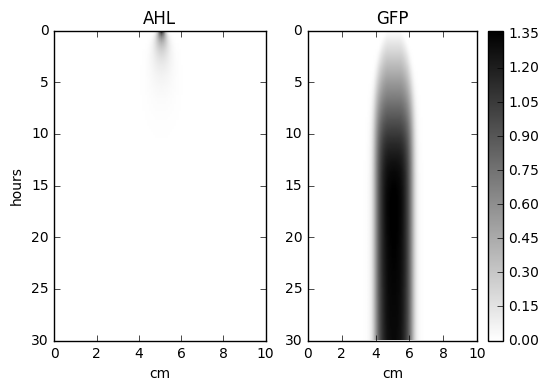

In [108]:
plt.subplot(121)
plt.imshow(a, extent=(0,size*100,T,0), aspect='auto', cmap='binary')
plt.ylabel('hours')
plt.xlabel('cm')
plt.title('AHL')
plt.subplot(122)
plt.imshow(g, extent=(0,size*100,T,0), aspect='auto', cmap='binary')
plt.xlabel('cm')
plt.title('GFP')
plt.colorbar();

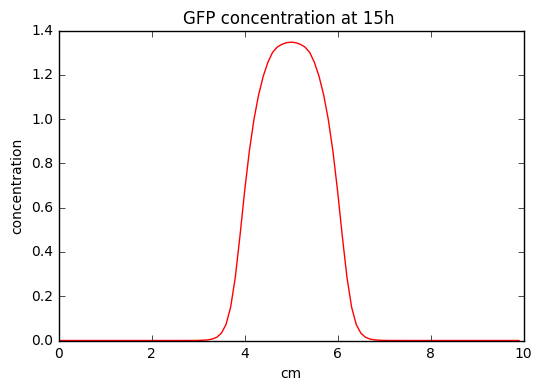

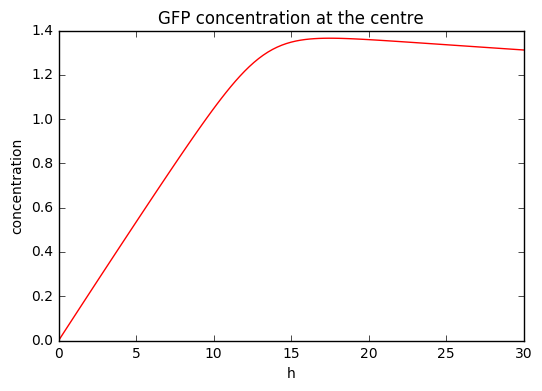

In [129]:
plt.figure(1)
plt.plot(100*x[:-1],g[50,:], 'r')
plt.ylabel('concentration')
plt.xlabel('cm')
plt.title('GFP concentration at 15h ')

plt.figure(2)
plt.plot(t/3600,g[:,50], 'r')
plt.ylabel('concentration')
plt.xlabel('h')
plt.title('GFP concentration at the centre')
plt.show()

In [78]:
#front width dependence on initial concentration
logRange=np.arange(1,1000,10)
parSpace = np.zeros((len(logRange),2))
x = np.linspace(0, size, 101)
dx = x[1] - x[0]
t = np.linspace(0, T*3600, 101)

i=0
for aConcScale in logRange:
    a0 = aConcScale*gaussian(x, 0.05, 0.001)
    g0 = np.zeros_like(a0)
    y0 = np.append(a0,g0)

    y = odeint(reactiondiffusion, y0, t, (Da,delta_a,n,Ka,alpha_g,delta_g))
    varLength = int(len(y[0,:])/2)
    a = y[:,0:varLength-1]
    g = y[:,varLength:-1]
    parSpace[i,0] = frontWidth(g)
    parSpace[i,1] = np.max(a0)
    i+=1

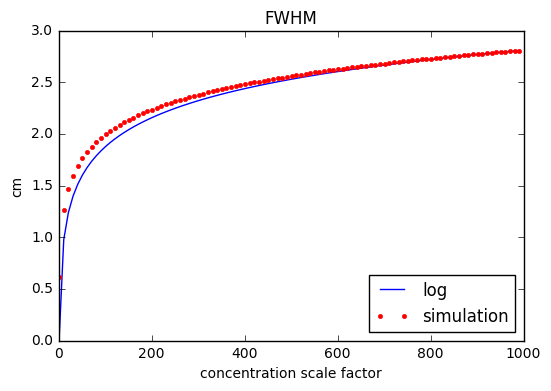

In [110]:
scalingFactor = max(parSpace[:,0])/max(np.log(logRange))
plt.plot(logRange, 100*scalingFactor*np.log(logRange), 'b', label='log')
plt.plot(logRange, 100*parSpace[:,0], 'r.', label='simulation')
plt.ylabel('cm')
plt.xlabel('concentration scale factor')
plt.title('FWHM')
plt.legend(loc=4)
plt.show()